# 6. Advance

Load lại data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import joblib

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline

from lightgbm import LGBMRegressor
from scipy.stats import skew

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
data = pd.read_csv(filepath_or_buffer="../data/house_price.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Chuyển "YearBuilt" và "YearRemodAdd" thành tuổi

In [3]:
data["HouseAge"] = data["YrSold"] - data["YearBuilt"]
data["RemodelAge"] = data["YrSold"] - data["YearRemodAdd"]

data = data.drop(columns=["YearBuilt", "YearRemodAdd", "YrSold"])

Lấy các đặc trưng đã chọn

In [4]:
mi_columns = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'ExterQual', 'BsmtQual', 'KitchenQual', '1stFlrSF', 'GarageArea', 'HouseAge',
              'MSSubClass', 'GarageFinish', 'FullBath', 'LotFrontage', '2ndFlrSF', 'LotArea', 'TotRmsAbvGrd', 'RemodelAge', 'BsmtFinSF1', 'HeatingQC',
              'Fireplaces', 'OpenPorchSF', 'BsmtUnfSF', 'OverallCond', 'MasVnrArea', 'HalfBath', 'BsmtExposure', 'GarageCond', 'WoodDeckSF',
              'GarageQual', 'CentralAir', 'BedroomAbvGr', 'BsmtCond', 'PavedDrive', 'KitchenAbvGr', 'BsmtFullBath', 'ExterCond', 'ScreenPorch',
              'EnclosedPorch', 'BsmtHalfBath',
              'Neighborhood', 'GarageType', 'Foundation', 'Exterior2nd', 'BsmtFinType1', 'Exterior1st', 'MSZoning', 'MasVnrType', 'LotShape',
              'HouseStyle', 'SaleType', 'SaleCondition', 'Electrical', 'BldgType', 'BsmtFinType2', 'LandContour', 'Condition1', 'Heating', 'RoofStyle',
              'LotConfig', 'SalePrice']
data = data[mi_columns]

Xử lý giá trị NaN và các outlier.

In [5]:
fillna_values = {
    "LotFrontage": 0,
    "MasVnrType": "None",
    "MasVnrArea": 0,
    "BsmtQual": "No_bsmt",
    "BsmtCond": "No_bsmt",
    "BsmtExposure": "No_bsmt",
    "BsmtFinType1": "No_bsmt",
    "BsmtFinType2": "No_bsmt",
    "Electrical": "None",
    "GarageType": "No_gara",
    "GarageFinish": "No_gara",
    "GarageQual": "No_gara",
    "GarageCond": "No_gara",
}
data = data.fillna(value=fillna_values)

In [6]:
# Sort data by "SalePrice" then remove 2 largest values
data = data.sort_values(by="SalePrice", ascending=False)
data = data.drop(index=[data.index[0], data.index[1]])

# Sort data by "SalePrice" then remove 5 smallest values
data = data.sort_values(by="SalePrice", ascending=True)
data = data.drop(index=[data.index[0], data.index[1], data.index[2], data.index[3], data.index[4]])

# Sort data by "LotFrontage" then remove largest value
data = data.sort_values(by="LotFrontage", ascending=False)
data = data.drop(index=[data.index[0], data.index[1]])

# Sort data by "LotArea" then remove 4 largest values
data = data.sort_values(by="LotArea", ascending=False)
data = data.drop(index=[data.index[0], data.index[1], data.index[2], data.index[3]])

# Sort data by "GrLivArea" then remove largest value
data = data.sort_values(by="GrLivArea", ascending=False)
data = data.drop(index=[data.index[0]])

Label Encoding

In [7]:
data["ExterQual"] = data["ExterQual"].map({"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
data["ExterCond"] = data["ExterCond"].map({"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
data["BsmtQual"] = data["BsmtQual"].map({"No_bsmt": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
data["BsmtCond"] = data["BsmtCond"].map({"No_bsmt": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
data["BsmtExposure"] = data["BsmtExposure"].map({"No_bsmt": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4})
data["HeatingQC"] =data["HeatingQC"].map({"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
data["CentralAir"] =data["CentralAir"].map({"N": 0, "Y": 1})
data["KitchenQual"] = data["KitchenQual"].map({"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
data["GarageFinish"] = data["GarageFinish"].map({"No_gara": 0, "Unf": 1, "RFn": 2, "Fin": 3})
data["GarageQual"] = data["GarageQual"].map({"No_gara": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
data["GarageCond"] = data["GarageCond"].map({"No_gara": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
data["PavedDrive"] = data["PavedDrive"].map({"N": 0, "P": 1, "Y": 2})

Xử lý các cột dạng số không có phân phối đều

In [8]:
numerical_columns = data.select_dtypes(exclude=["object"]).columns.tolist()

skewed_features = data[numerical_columns].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

for f in skewed_features:
    data[f] = np.log1p(data[f])

Mã hóa one-hot cho tát cả các cột dạng category. Sau đó phân chia thành dữ liệu huấn luyện và kiểm tra.

In [9]:
X = data.drop(columns=["SalePrice"])
y = data["SalePrice"]

X = pd.get_dummies(data=X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Chuẩn hóa các cột dạng số về khoảng giá trị 0 đến 1

In [10]:
numerical_columns.remove("SalePrice")

scaler = MinMaxScaler()
scaler.fit(X=X_train[numerical_columns])

X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

Lập mô hình

In [11]:
def get_result(model, X_test, y_test=y_test):
    predictions = model.predict(X_test)
    r2 = r2_score(y_true=np.expm1(y_test), y_pred=np.expm1(predictions))
    mape = mean_absolute_percentage_error(y_true=np.expm1(y_test), y_pred=np.expm1(predictions))
    return {"MAPE": mape*100, "R2 score": r2}

In [12]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_result = get_result(lasso_model, X_test=X_test)

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_result = get_result(ridge_model, X_test=X_test)

elastic_model = ElasticNet()
elastic_model.fit(X_train, y_train)
elastic_result = get_result(elastic_model, X_test=X_test)

random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
random_forest_result = get_result(random_forest, X_test=X_test)

SVR_model = SVR()
SVR_model.fit(X_train, y_train)
SVR_result = get_result(SVR_model, X_test=X_test)

LGBM_model = LGBMRegressor()
LGBM_model.fit(X_train, y_train)
LGBM_result = get_result(LGBM_model, X_test=X_test)

In [13]:
all_results = pd.DataFrame({
    "Lasso": lasso_result,
    "Ridge": ridge_result,
    "ElasticNet": elastic_result,
    "Random forest": random_forest_result,
    "SVR": SVR_result,
    "LGBM": LGBM_result
})

all_results.transpose().sort_values(by="MAPE", ascending=True)

,MAPE,R2 score
Ridge,7.5760,0.9332
LGBM,8.6180,0.9100
SVR,8.6810,0.9123
Random forest,9.9676,0.8810
Lasso,30.4453,-0.0294
ElasticNet,30.4453,-0.0294


Tạo lại các mô hình của chúng ta. Do các mô hình Lasso, Ridge, ElasticNet và SVR không hoạt động tốt với outlier (mà chúng ta lại có khá nhiều outliers trong dữ liệu) nên lần này ta sẽ dùng RobustScaler trước để tăng chất lượng

In [14]:
ridge_model_2 = make_pipeline(RobustScaler(), Ridge())
ridge_model_2.fit(X_train, y_train)
ridge_result_2 = get_result(ridge_model_2, X_test=X_test)
ridge_result_2

{'MAPE': 7.548599102024594, 'R2 score': 0.9333542521284866}

Chất lượng có cải thiện khi thêm RobustScaler.

Để tìm tham số tốt nhất cho các mô hình ta dùng GridSearchCV.

Đầu tiên là tìm tham số điều chuẩn "alpha" cho mô hình Lasso:

In [15]:
# Tìm tham số alpha cho mô hình Lasso
lasso_param = {"lasso__alpha": [0.0005, 0.0006, 0.0007]}
lasso_model_search = make_pipeline(RobustScaler(), Lasso())
lasso_search = GridSearchCV(estimator=lasso_model_search, param_grid=lasso_param)
lasso_search.fit(X_train, y_train)
lasso_search.best_params_

{'lasso__alpha': 0.0006}

In [16]:
# Tạo model Lasso & lấy kết quả
lasso_model = make_pipeline(RobustScaler(), Lasso(alpha=0.0006))
lasso_model.fit(X_train, y_train)
lasso_result_1 = get_result(lasso_model, X_test=X_test)
lasso_result_1

{'MAPE': 7.330565078753752, 'R2 score': 0.9350646662586036}

Tiếp đến Ridge

In [17]:
# Tìm tham số alpha cho mô hình Ridge
ridge_param = {"ridge__alpha": [15, 16, 17]}
ridge_model_search = make_pipeline(RobustScaler(), Ridge())
ridge_search = GridSearchCV(estimator=ridge_model_search, param_grid=ridge_param)
ridge_search.fit(X_train, y_train)
ridge_search.best_params_

{'ridge__alpha': 16}

In [18]:
# Tạo model Ridge & lấy kết quả
ridge_model = make_pipeline(RobustScaler(), Ridge(alpha=16))
ridge_model.fit(X_train, y_train)
ridge_result_1 = get_result(ridge_model, X_test=X_test)
ridge_result_1

{'MAPE': 7.255224232045644, 'R2 score': 0.9364922429950249}

Tiếp tục với ElasticNet. Do ElasticNet kết hợp cả điều chuẩn L1 và L2 nên chúng ta cần khám phá cả tỉ lệ của chúng nữa

In [19]:
# Tìm tham số cho mô hình ElasticNet
elastic_param = {"elasticnet__alpha": [0.0008, 0.0009, 0.001], "elasticnet__l1_ratio": [0.61, 0.62, 0.63]}
elastic_model_search = make_pipeline(RobustScaler(), ElasticNet())
elastic_search = GridSearchCV(estimator=elastic_model_search, param_grid=elastic_param)
elastic_search.fit(X_train, y_train)
elastic_search.best_params_

{'elasticnet__alpha': 0.0009, 'elasticnet__l1_ratio': 0.62}

In [20]:
# Tạo model ElasticNet & lấy kết quả
elastic_model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0009, l1_ratio=0.62))
elastic_model.fit(X_train, y_train)
elastic_result_1 = get_result(elastic_model, X_test=X_test)
elastic_result_1

{'MAPE': 7.324726749195697, 'R2 score': 0.9350961955760414}

Có rất nhiều tham số trong mô hình RandomForestRegressor nhưng chúng ta sẽ chỉ tập trung vào 3 tham số cơ bản sau:
- n_estimators: số cây quyết định được dùng
- min_samples_split: số mẫu tối thiểu để tiếp tục phân nhánh cho node đó
- min_samples_leaf: số mẫu tối thiểu ở một lá (leaf node)

In [24]:
random_forest_param = {
    "n_estimators": [100, 120, 140, 160],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3]
}
random_forest_model = RandomForestRegressor()
random_forest_search = GridSearchCV(estimator=random_forest_model, param_grid=random_forest_param)
random_forest_search.fit(X_train, y_train)
random_forest_search.best_params_

# It takes very long to run this cell, below is the result in case Outputs of this cell is cleared
# {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120}

{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120}

In [27]:
random_forest = RandomForestRegressor(n_estimators=120, min_samples_leaf=2)
random_forest.fit(X_train, y_train)
random_forest_result_1 = get_result(random_forest, X_test=X_test)
random_forest_result_1

{'MAPE': 9.787797319502873, 'R2 score': 0.8831989196595826}

Chất lượng của Random Forest tăng một chút. Lưu ý Random Forest hoạt động dựa trên các cây quyết định, mà decision tree thì mỗi lần chạy sẽ cho kết quả khác nhau (chúng ta được khuyên rằng hãy huấn luyện mô hình decision tree nhiều lần và chọn mô hình có kết quả tốt nhất).

Ở mô hình SVR ta cũng sẽ chỉ điều chỉnh 3 tham số cơ bản:
- gamma: hệ số cho nhân "rbf"
- C: chỉ số điều chuẩn (càng lớn thì điều chuẩn càng giảm)
- epsilon: nếu dự đoán tại một điểm có sai số nhỏ hơn epsilon thì không áp dụng điều chuẩn tại điểm đó

In [30]:
# Tìm tham số cho mô hình SVR
SVR_param = {
    "svr__gamma": ["scale", "auto"],
    "svr__C": [1.9, 2, 2.1],
    "svr__epsilon": [0.009, 0.01, 0.011]
}
SVR_model_search = make_pipeline(RobustScaler(), SVR())
SVR_search = GridSearchCV(estimator=SVR_model_search, param_grid=SVR_param)
SVR_search.fit(X_train, y_train)
SVR_search.best_params_

# # It takes very long to run this cell, below is the result in case Outputs of this cell is cleared
# {'svr__C': 2, 'svr__epsilon': 0.01, 'svr__gamma': 'auto'}

{'svr__C': 2, 'svr__epsilon': 0.01, 'svr__gamma': 'auto'}

In [31]:
# Tạo model SVR & lấy kết quả
SVR_model = make_pipeline(RobustScaler(), SVR(gamma="auto", C=2, epsilon=0.01))
SVR_model.fit(X_train, y_train)
SVR_result_1 = get_result(SVR_model, X_test=X_test)
SVR_result_1

{'MAPE': 6.979686323423992, 'R2 score': 0.9388084533159239}

Cuối cùng là LGBM, tập trung vào 6 trong số rất nhiều tham số của mô hình:
- num_leaves: số "lá" tối đa của một "cây"
- learning_rate: tốc độ học
- n_estimators: số lượng cây tăng cường dùng trong mô hình
- min_child_samples: số lượng tối thiểu cần có trong 1 lá
- reg_alpha: điều chuẩn L1 trên trọng số
- reg_lambda: điều chuẩn L2 trên trọng số

In [37]:
# Tìm tham số cho mô hình LGBM
LGBM_param = {
    "num_leaves": [2, 3],
    "learning_rate": [0.04, 0.05, 0.06],
    "n_estimators": [2900, 3000, 3100],
    "min_child_samples": [13, 14, 15],
    "reg_alpha": [0.002, 0.003, 0.004],
    "reg_lambda": [0.001, 0.0011, 0.0012]
}
LGBM_model_search = LGBMRegressor()
LGBM_search = GridSearchCV(estimator=LGBM_model_search, param_grid=LGBM_param)
LGBM_search.fit(X_train, y_train)
LGBM_search.best_params_

# It takes very long to run this cell, below is the result in case Outputs of this cell is cleared
# {'learning_rate': 0.05, 'min_child_samples': 14, 'n_estimators': 3000, 'num_leaves': 2, 'reg_alpha': 0.003, 'reg_lambda': 0.0011}

{'learning_rate': 0.05,
 'min_child_samples': 14,
 'n_estimators': 3000,
 'num_leaves': 2,
 'reg_alpha': 0.003,
 'reg_lambda': 0.0011}

In [38]:
LGBM_model = LGBMRegressor(num_leaves=2, learning_rate=0.05, n_estimators=3000, min_child_samples=14, reg_alpha=0.003, reg_lambda=0.0011)
LGBM_model.fit(X_train, y_train)
LGBM_result_1 = get_result(LGBM_model, X_test=X_test)
LGBM_result_1

{'MAPE': 7.7815082050627105, 'R2 score': 0.9272029487952697}

Chất lượng tăng lên so với mặc định. Chú ý là tính chất mô hình LGBM cũng dựa trên các cây quyết định như Random Forest.

Ngoài ra ta cũng cần lưu ý là GridSearchCV tim ra giá trị tham số hoạt động tốt nhất dựa trên tập huấn luyện nên rất có khà năng overfitting tập huấn luyện, nghĩa là các tham số đó chỉ cho kết quả tốt nhất khi đánh giá trên tập huấn luyện nhưng khi dùng mô hình đó cho tập kiểm định thì kết quả không tốt.

**NOTE:** việc tuning ở trên được thực hiện nhiều lần. Ban đầu chọn một số giá trị xung quanh giá trị mặc định (hoặc nhỏ/lớn hơn giá trị mặc định tùy tham số), sau đó tùy thuộc giá trị tốt nhất tìm được mà xê dịch khoảng giá trị lựa chọn nhỏ/lớn hơn hoặc tập trung vào một khoảng chi tiết hơn (zooming).

Hãy xem lại kết quả các mô hình của chúng ta sau khi tuning:

In [39]:
all_results_1 = pd.DataFrame({
    "Lasso": lasso_result_1,
    "Ridge": ridge_result_1,
    "ElasticNet": elastic_result_1,
    "Random forest": random_forest_result_1,
    "SVR": SVR_result_1,
    "LGBM": LGBM_result_1
})

all_results_1.transpose().sort_values(by="MAPE", ascending=True)

,MAPE,R2 score
SVR,6.9797,0.9388
Ridge,7.2552,0.9365
ElasticNet,7.3247,0.9351
Lasso,7.3306,0.9351
LGBM,7.7815,0.9272
Random forest,9.7878,0.8832


In [40]:
pd.concat(objs=[all_results.transpose(), all_results_1.transpose()], axis=1, keys=["Before tuning", "After tuning"])

Before tuning          After tuning         
                       MAPE R2 score         MAPE R2 score
Lasso               30.4453  -0.0294       7.3306   0.9351
Ridge                7.5760   0.9332       7.2552   0.9365
ElasticNet          30.4453  -0.0294       7.3247   0.9351
Random forest        9.9676   0.8810       9.7878   0.8832
SVR                  8.6810   0.9123       6.9797   0.9388
LGBM                 8.6180   0.9100       7.7815   0.9272

Hãy thử mô hình neural network xem sao

In [41]:
# Create Dataset for faster process with tensorflow
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_data = train_data.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)

# Create a list of callback functions
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, mode="min"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=9, mode="min")
]

X_train.shape

(1156, 200)

In [44]:
# Create model
NN_model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Dense(units=256, activation="relu", input_shape=(200,)),
    tf.keras.layers.Dense(units=1, activation="relu")
])

# Compile model
NN_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["mape"])

In [45]:
# Train model
history = NN_model.fit(x=train_data,
                        epochs=500,
                        callbacks=callbacks_list,
                        validation_data=test_data,
                        steps_per_epoch=len(train_data),
                        validation_steps=len(test_data))

Epoch 1/500
19/19 [==============================] - 1s 12ms/step - loss: 78.9339 - mape: 71.4618 - val_loss: 14.2745 - val_mape: 31.2331 - lr: 0.0010
Epoch 2/500
19/19 [==============================] - 0s 6ms/step - loss: 3.8769 - mape: 13.8563 - val_loss: 3.3188 - val_mape: 13.9981 - lr: 0.0010
Epoch 3/500
19/19 [==============================] - 0s 5ms/step - loss: 1.1923 - mape: 7.1482 - val_loss: 0.6091 - val_mape: 5.1948 - lr: 0.0010
Epoch 4/500
19/19 [==============================] - 0s 5ms/step - loss: 0.4455 - mape: 4.3229 - val_loss: 0.2978 - val_mape: 3.5013 - lr: 0.0010
Epoch 5/500
19/19 [==============================] - 0s 6ms/step - loss: 0.2617 - mape: 3.3058 - val_loss: 0.2416 - val_mape: 3.1231 - lr: 0.0010
Epoch 6/500
19/19 [==============================] - 0s 5ms/step - loss: 0.2038 - mape: 2.9054 - val_loss: 0.2057 - val_mape: 2.8972 - lr: 0.0010
Epoch 7/500
19/19 [==============================] - 0s 6ms/step - loss: 0.1680 - mape: 2.6455 - val_loss: 0.1775 - v

In [46]:
NN_result = get_result(NN_model, X_test=X_test)

all_results_1 = pd.DataFrame({
    "Lasso": lasso_result_1,
    "Ridge": ridge_result_1,
    "ElasticNet": elastic_result_1,
    "Random forest": random_forest_result_1,
    "SVR": SVR_result_1,
    "LGBM": LGBM_result_1,
    "Neural network": NN_result
})

all_results_1.transpose().sort_values(by="MAPE", ascending=True)

,MAPE,R2 score
SVR,6.9797,0.9388
Ridge,7.2552,0.9365
ElasticNet,7.3247,0.9351
Lasso,7.3306,0.9351
LGBM,7.7815,0.9272
Random forest,9.7878,0.8832
Neural network,11.6575,0.8616


Mô hình NN bị overfit và kết quả không được như các mô hình khác. Thông thường NN model chỉ hoạt động tốt khi có nhiều dữ liệu.

Cuối cùng chúng ta sẽ thử ensemble learning.

In [47]:
lasso_model_ensemble = make_pipeline(RobustScaler(), Lasso(alpha=0.0006))
ridge_model_ensemble = make_pipeline(RobustScaler(), Ridge(alpha=16))
elastic_model_ensemble = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0009, l1_ratio=0.62))
random_forest_ensemble = RandomForestRegressor(n_estimators=120, min_samples_leaf=2)
SVR_model_ensemble = make_pipeline(RobustScaler(), SVR(gamma="auto", C=2, epsilon=0.01))
LGBM_model_ensemble = LGBMRegressor(num_leaves=2, learning_rate=0.05, n_estimators=3000, min_child_samples=14, reg_alpha=0.003, reg_lambda=0.0011)

Kết hợp 3 mô hình tốt nhất

In [48]:
top_3_param = {
    "weights": [None, [8, 1, 1], [7, 2, 1], [6, 3, 1], [6, 2, 2], [5, 4, 1], [5, 3, 2], [4, 4, 2], [4, 3, 3]]
}

top_3_estimators = [("SVR", SVR_model_ensemble), ("Ridge", ridge_model_ensemble), ("Elastic", elastic_model_ensemble)]

top_3_model_search = VotingRegressor(estimators=top_3_estimators)
top_3_search = GridSearchCV(estimator=top_3_model_search, param_grid=top_3_param)
top_3_search.fit(X_train, y_train)
top_3_search.best_params_

{'weights': [8, 1, 1]}

In [49]:
top_3_model = VotingRegressor(estimators=top_3_estimators, weights=[8, 1, 1])
top_3_model.fit(X_train, y_train)
top_3_result = get_result(top_3_model, X_test=X_test)
top_3_result

{'MAPE': 6.90228756670271, 'R2 score': 0.9403436801419496}

Top 4

In [50]:
top_4_param = {
    "weights": [None, [7, 1, 1, 1], [6, 2, 1, 1], [5, 3, 1, 1], [5, 2, 2, 1], [4, 4, 1, 1], [4, 3, 2, 1], [4, 2, 2, 2], [3, 3, 3, 1], [3, 3, 2, 2]]
}

top_4_estimators = [("SVR", SVR_model_ensemble), ("Ridge", ridge_model_ensemble), ("Elastic", elastic_model_ensemble), ("Lasso", lasso_model_ensemble)]

top_4_model_search = VotingRegressor(estimators=top_4_estimators)
top_4_search = GridSearchCV(estimator=top_4_model_search, param_grid=top_4_param)
top_4_search.fit(X_train, y_train)
top_4_search.best_params_

{'weights': [7, 1, 1, 1]}

In [51]:
top_4_model = VotingRegressor(estimators=top_4_estimators, weights=[7, 1, 1, 1])
top_4_model.fit(X_train, y_train)
top_4_result = get_result(top_4_model, X_test=X_test)
top_4_result

{'MAPE': 6.888763890481709, 'R2 score': 0.9407580854873347}

Top 5

In [52]:
top_5_param = {
    "weights": [None, [6, 1, 1, 1, 1], [5, 2, 1, 1, 1], [4, 3, 1, 1, 1], [4, 2, 2, 1, 1], [3, 3, 2, 1, 1], [3, 2, 2, 2, 1]]
}

top_5_estimators = [("SVR", SVR_model_ensemble), ("Ridge", ridge_model_ensemble), ("Elastic", elastic_model_ensemble),
                    ("Lasso", lasso_model_ensemble), ("LGBM", LGBM_model_ensemble)]

top_5_model_search = VotingRegressor(estimators=top_5_estimators)
top_5_search = GridSearchCV(estimator=top_5_model_search, param_grid=top_5_param)
top_5_search.fit(X_train, y_train)
top_5_search.best_params_

{'weights': [6, 1, 1, 1, 1]}

In [53]:
top_5_model = VotingRegressor(estimators=top_5_estimators, weights=[6, 1, 1, 1, 1])
top_5_model.fit(X_train, y_train)
top_5_result = get_result(top_5_model, X_test=X_test)
top_5_result

{'MAPE': 6.882211774360643, 'R2 score': 0.9407867720867024}

Kết hợp tất cả 6 mô hình

In [54]:
ensemble_param = {
    "weights": [None, [5, 1, 1, 1, 1, 1], [4, 2, 1, 1, 1, 1], [3, 3, 1, 1, 1, 1], [3, 2, 2, 1, 1, 1], [2, 2, 2, 2, 1, 1]]
}

ensemble_estimators = [("SVR", SVR_model_ensemble), ("Ridge", ridge_model_ensemble), ("Elastic", elastic_model_ensemble), 
                       ("Lasso", lasso_model_ensemble), ("LGBM", LGBM_model_ensemble), ("Random Forest", random_forest_ensemble)]

ensemble_model_search = VotingRegressor(estimators=ensemble_estimators)
ensemble_search = GridSearchCV(estimator=ensemble_model_search, param_grid=ensemble_param)
ensemble_search.fit(X_train, y_train)
ensemble_search.best_params_

{'weights': [5, 1, 1, 1, 1, 1]}

In [55]:
ensemble_model = VotingRegressor(estimators=ensemble_estimators, weights=[5, 1, 1, 1, 1, 1])
ensemble_model.fit(X_train, y_train)
ensemble_result = get_result(ensemble_model, X_test=X_test)
ensemble_result

{'MAPE': 6.90096070495296, 'R2 score': 0.9396169949503611}

In [56]:
all_results_1 = pd.DataFrame({
    "Lasso": lasso_result_1,
    "Ridge": ridge_result_1,
    "ElasticNet": elastic_result_1,
    "Random forest": random_forest_result_1,
    "SVR": SVR_result_1,
    "LGBM": LGBM_result_1,
    "Top 3": top_3_result,
    "Top 4": top_4_result,
    "Top 5": top_5_result,
    "All 6 model": ensemble_result
})

all_results_1.transpose().sort_values(by="MAPE", ascending=True)

,MAPE,R2 score
Top 5,6.8822,0.9408
Top 4,6.8888,0.9408
All 6 model,6.9010,0.9396
Top 3,6.9023,0.9403
SVR,6.9797,0.9388
Ridge,7.2552,0.9365
ElasticNet,7.3247,0.9351
Lasso,7.3306,0.9351
LGBM,7.7815,0.9272
Random forest,9.7878,0.8832


Hãy lấy ra các dự đoán sai nhất để quan sát

In [58]:
columns = X_test.columns.to_list()
dummy_columns = [x for x in columns if x not in numerical_columns]

check_error_1 = pd.from_dummies(data=X_test[dummy_columns], sep="_")
check_error_1.reset_index(drop=True, inplace=True)

check_error_2 = X_test[numerical_columns].reset_index(drop=True)

check_error = pd.concat(objs=[check_error_2, check_error_1], axis=1)
check_error[numerical_columns] = scaler.inverse_transform(check_error[numerical_columns])

for f in skewed_features:
    if f == "SalePrice":
        continue
    check_error[f] = np.expm1(check_error[f])
    
check_error["Price"] = y_test.reset_index(drop=True)
check_error["Predict"] = top_5_model.predict(X=X_test)

check_error["Price"] = np.expm1(check_error["Price"])
check_error["Predict"] = np.expm1(check_error["Predict"])

check_error["Difference"] = (check_error["Predict"] - check_error["Price"]) / check_error["Price"] * 100
check_error["Difference"] = check_error["Difference"].abs()

check_error.sort_values(by="Difference", inplace=True)
show_columns = ["OverallQual", "GrLivArea", "GarageCars", "Neighborhood", "ExterQual", "BsmtQual", "KitchenQual", "Price", "Predict", "Difference"]
check_error[show_columns].tail(10)

,OverallQual,GrLivArea,GarageCars,Neighborhood,ExterQual,BsmtQual,KitchenQual,Price,Predict,Difference
35,4.0000,864.0000,2.0000,NAmes,3.0000,3.0000,3.0000,"97,000.0000","117,703.2936",21.3436
241,6.0000,987.0000,1.0000,BrDale,3.0000,3.0000,3.0000,"83,000.0000","101,224.3931",21.9571
24,8.0000,"1,752.0000",2.0000,Gilbert,4.0000,4.0000,3.0000,"164,000.0000","204,200.6548",24.5126
277,4.0000,960.0000,1.0000,Edwards,3.0000,3.0000,3.0000,"112,000.0000","84,364.2802",24.6747
18,5.0000,"1,006.0000",0.0000,Sawyer,3.0000,3.0000,3.0000,"80,000.0000","100,757.0869",25.9464
115,6.0000,"2,201.0000",2.0000,Edwards,4.0000,4.0000,4.0000,"274,970.0000","191,271.3842",30.4392
54,6.0000,"1,392.0000",2.0000,NAmes,3.0000,2.0000,3.0000,"110,000.0000","144,714.2308",31.5584
15,3.0000,894.0000,3.0000,IDOTRR,2.0000,3.0000,3.0000,"81,000.0000","106,959.0007",32.0481
156,5.0000,"1,140.0000",0.0000,Mitchel,3.0000,4.0000,3.0000,"84,500.0000","137,291.9162",62.4756
158,8.0000,"1,795.0000",3.0000,Somerst,4.0000,5.0000,4.0000,"147,000.0000","287,289.1801",95.4348


Dự đoán sai nhất của mô hình có vẻ là một điểm dữ liệu không chính xác. Tất cả các đặc trưng đều cho thấy đây là ngôi nhà tốt nhưng giá lại thấp hơn gần một nửa so với dự đoán.

Thử nhóm dữ liệu theo 2 trường có ảnh hưởng lớn nhất là "OverallQual" và "Neighborhood"

In [59]:
check_mean_columns = ["OverallQual", "Neighborhood", "Price", "Predict", "Difference"]
check_mean = check_error[check_mean_columns].groupby(by=["OverallQual", "Neighborhood"], as_index=False).mean()

check_mean.sort_values(by="Difference", inplace=True)
check_mean.tail(10)

,OverallQual,Neighborhood,Price,Predict,Difference
14,5.0000,BrkSide,"140,000.0000","121,989.1784",12.5431
29,6.0000,BrDale,"89,466.6667","100,104.8121",12.6417
33,6.0000,Edwards,"186,995.7143","163,891.9140",12.7366
21,5.0000,Mitchel,"132,650.0000","139,812.1063",12.8018
30,6.0000,BrkSide,"210,000.0000","182,443.5715",13.1221
69,8.0000,Somerst,"246,113.6364","250,985.9051",13.2255
76,9.0000,Timber,"378,500.0000","322,494.0313",14.7968
6,4.0000,IDOTRR,"55,000.0000","65,009.5319",18.1991
64,8.0000,Gilbert,"164,000.0000","204,200.6548",24.5126
2,3.0000,IDOTRR,"81,000.0000","106,959.0007",32.0481


Dự đoán sai lệch thế nào với các nhóm "OverallQual"

In [60]:
check_error[["OverallQual", "Price", "Predict", "Difference"]].groupby(by=["OverallQual"], as_index=False).mean()

,OverallQual,Price,Predict,Difference
0,2.0000,"60,000.0000","62,017.5918",4.5442
1,3.0000,"88,000.0000","104,617.3416",19.8534
2,4.0000,"109,885.0000","103,868.0568",10.8933
3,5.0000,"134,381.8000","133,537.0730",5.8827
4,6.0000,"161,409.4493","158,701.1485",7.5206
5,7.0000,"197,990.7049","197,120.8030",5.3769
6,8.0000,"266,853.6667","266,652.3410",7.9831
7,9.0000,"363,897.6000","362,781.9523",6.3083
8,10.0000,"458,475.0000","440,485.5441",3.9073


Các ngôi nhà chất lượng thấp có dự đoán sai nhiều hơn

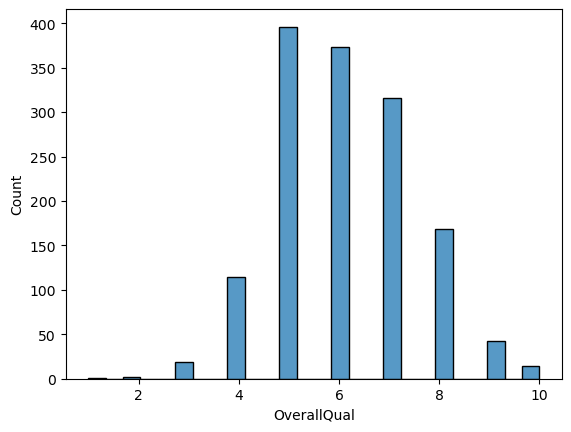

In [61]:
sns.histplot(data["OverallQual"])
plt.show()

Ta sẽ cần thu thập thêm dữ liệu cho các ngôi nhà có chất lượng thấp < 4 và cao > 8

Xem xét nhóm có dự đoán sai nhất "OverallQual" = 3 & "Neighborhood" = "IDOTRR"

In [63]:
check_price = data[["OverallQual", "GrLivArea", "GarageCars", "Neighborhood", "ExterQual", "BsmtQual", "KitchenQual", "SalePrice"]].copy()

for f in skewed_features:
    if f in check_price.columns:
        check_price[f] = np.expm1(check_price[f])

check_price[(check_price["OverallQual"] == 3) & (check_price["Neighborhood"] == "IDOTRR")]

,OverallQual,GrLivArea,GarageCars,Neighborhood,ExterQual,BsmtQual,KitchenQual,SalePrice
88,3,"1,526.0000",0,IDOTRR,2.0000,3,2,"85,000.0000"
998,3,"1,077.0000",1,IDOTRR,3.0000,3,3,"91,000.0000"
1061,3,894.0000,3,IDOTRR,2.0000,3,3,"81,000.0000"


Chỉ có 3 điểm dữ liệu, điều này khiến mô hình dự đoán chưa chính xác

Kiểm tra nhóm mà dự đoán sai nhất nằm trong đó

In [64]:
check_error[show_columns].tail(1)

,OverallQual,GrLivArea,GarageCars,Neighborhood,ExterQual,BsmtQual,KitchenQual,Price,Predict,Difference
158,8.0000,"1,795.0000",3.0000,Somerst,4.0000,5.0000,4.0000,"147,000.0000","287,289.1801",95.4348


In [65]:
check_price[(check_price["OverallQual"] == 8) & (check_price["Neighborhood"] == "Somerst")].describe()

,OverallQual,GrLivArea,GarageCars,ExterQual,BsmtQual,KitchenQual,SalePrice
count,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000
mean,8.0000,"1,729.8966",2.5172,3.9655,4.2069,4.1034,"255,626.1379"
std,0.0000,313.9503,0.5085,0.1857,0.4123,0.4093,"55,302.6318"
min,8.0000,"1,247.0000",2.0000,3.0000,4.0000,3.0000,"147,000.0000"
25%,8.0000,"1,563.0000",2.0000,4.0000,4.0000,4.0000,"229,456.0000"
50%,8.0000,"1,636.0000",3.0000,4.0000,4.0000,4.0000,"250,000.0000"
75%,8.0000,"1,939.0000",3.0000,4.0000,4.0000,4.0000,"282,922.0000"
max,8.0000,"2,610.0000",3.0000,4.0000,5.0000,5.0000,"423,000.0000"


Nhóm này có giá dao động khá lớn từ 147,000 tới 423,000. Nhưng các điểm dữ liệu khác được dự đoán không sai quá nhiều (trung bình dự đoán sao của nhóm là 13.22% so với điểm dữ liệu sai nhất là 95.4%), khả năng cao đây là điểm dữ liệu bất thường, sai sót.

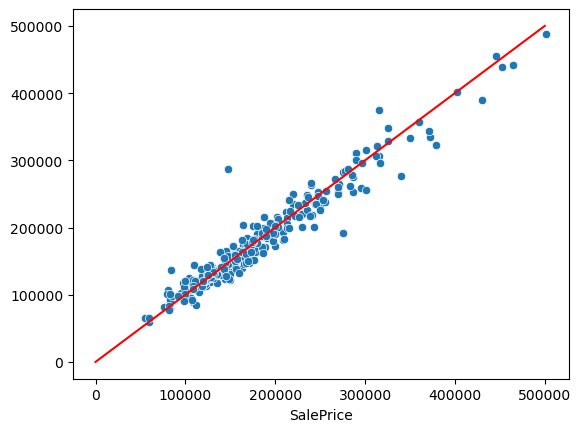

In [72]:
sns.scatterplot(x=np.expm1(y_test), y=np.expm1(top_5_model.predict(X=X_test)))
plt.plot([0, 500000], [0, 500000], "r")

Một số dữ liệu giá nhà có giá dao động lớn, hoặc chỉ có 1 vài ngôi nhà có đặc trưng như thế khiến mô hình dự đoán không được tốt lắm. Tuy nhiên số này không nhiều và nhìn chung mô hình học kết hợp của chúng ta làm việc khá tốt trên hầu hết dữ liệu.

Muốn cải thiện ta sẽ cần thu thập thêm dữ liệu về các ngôi nhà có chất lượng thấp dưới 4 và cao trên 8 để mô hình của chúng ta có thể học hết được các thông tin giá nhà.

Tạo lại mô hình, huấn luyện với toàn bộ dữ liệu và lưu chúng để có thể sử dụng sau này.

In [37]:
X_scaler = MinMaxScaler()
X_scaler.fit(X[numerical_columns])
X[numerical_columns] = X_scaler.transform(X[numerical_columns])

In [17]:
joblib.dump(value=X_scaler, filename="../src/models/scaler.joblib")

['../src/models/scaler.joblib']

In [73]:
top_5_model = VotingRegressor(estimators=top_5_estimators, weights=[6, 1, 1, 1, 1])
top_5_model.fit(X, y)

joblib.dump(value=top_5_model, filename="../src/models/ensemble_model.joblib")

['../src/models/ensemble_model.joblib']

Dự đoán bằng mô hình tốt nhất và submit để xem kết quả

In [ ]:
test_data = pd.read_csv(filepath_or_buffer="../data/test.csv")

test_data["HouseAge"] = test_data["YrSold"] - test_data["YearBuilt"]
test_data["RemodelAge"] = test_data["YrSold"] - test_data["YearRemodAdd"]

test_data = test_data.drop(columns=["YearBuilt", "YearRemodAdd", "YrSold"])

mi_columns = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'ExterQual', 'BsmtQual', 'KitchenQual', '1stFlrSF', 'GarageArea', 'HouseAge',
              'MSSubClass', 'GarageFinish', 'FullBath', 'LotFrontage', '2ndFlrSF', 'LotArea', 'TotRmsAbvGrd', 'RemodelAge', 'BsmtFinSF1', 'HeatingQC',
              'Fireplaces', 'OpenPorchSF', 'BsmtUnfSF', 'OverallCond', 'MasVnrArea', 'HalfBath', 'BsmtExposure', 'GarageCond', 'WoodDeckSF',
              'GarageQual', 'CentralAir', 'BedroomAbvGr', 'BsmtCond', 'PavedDrive', 'KitchenAbvGr', 'BsmtFullBath', 'ExterCond', 'ScreenPorch',
              'EnclosedPorch', 'BsmtHalfBath',
              'Neighborhood', 'GarageType', 'Foundation', 'Exterior2nd', 'BsmtFinType1', 'Exterior1st', 'MSZoning', 'MasVnrType', 'LotShape',
              'HouseStyle', 'SaleType', 'SaleCondition', 'Electrical', 'BldgType', 'BsmtFinType2', 'LandContour', 'Condition1', 'Heating', 'RoofStyle',
              'LotConfig']
test_data = test_data[mi_columns]

nan_columns = test_data.columns[test_data.isna().any()]
test_data[nan_columns].info()

In [55]:
fillna_values = {
    "GarageCars": 0,
    "TotalBsmtSF": 0,
    "BsmtQual": "No_bsmt",
    "KitchenQual": "No",
    "GarageArea": 0,
    "GarageFinish": "No_gara",
    "LotFrontage": 0,
    "BsmtFinSF1": 0,
    "BsmtUnfSF": 0,
    "MasVnrArea": 0,
    "BsmtExposure": "No_bsmt",
    "GarageCond": "No_gara",
    "GarageQual": "No_gara",
    "BsmtCond": "No_bsmt",
    "BsmtFullBath": 0,
    "BsmtHalfBath": 0,
    "GarageType": "No_gara",
    "Exterior2nd": "Other",
    "BsmtFinType1": "No_bsmt",
    "Exterior1st": "BrkComm",  # Can not use "Other" as our train data don't has it
    "MSZoning": "C (all)",
    "MasVnrType": "None",
    "SaleType": "Oth",
    "BsmtFinType2": "No_bsmt"
}
test_data = test_data.fillna(value=fillna_values)

In [56]:
test_data["ExterQual"] = test_data["ExterQual"].map({"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
test_data["ExterCond"] = test_data["ExterCond"].map({"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
test_data["BsmtQual"] = test_data["BsmtQual"].map({"No_bsmt": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
test_data["BsmtCond"] = test_data["BsmtCond"].map({"No_bsmt": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
test_data["BsmtExposure"] = test_data["BsmtExposure"].map({"No_bsmt": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4, "Ex": 5})
test_data["HeatingQC"] = test_data["HeatingQC"].map({"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
test_data["CentralAir"] = test_data["CentralAir"].map({"N": 0, "Y": 1})
test_data["KitchenQual"] = test_data["KitchenQual"].map({"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
test_data["GarageFinish"] = test_data["GarageFinish"].map({"No_gara": 0, "Unf": 1, "RFn": 2, "Fin": 3})
test_data["GarageQual"] = test_data["GarageQual"].map({"No_gara": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
test_data["GarageCond"] = test_data["GarageCond"].map({"No_gara": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
test_data["PavedDrive"] = test_data["PavedDrive"].map({"N": 0, "P": 1, "Y": 2})

In [57]:
for f in skewed_features:
    if f in mi_columns:
        test_data[f] = np.log1p(test_data[f])

test_data = pd.get_dummies(data=test_data)

In [59]:
# Make sure all dummy columns in out test data
one_hot_fields = ['Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
                  'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
                  'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
                  'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
                  'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
                  'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort',
                  'GarageType_Detchd', 'GarageType_No_gara',
                  'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood',
                  'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock',
                  'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other',
                  'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
                  'Exterior2nd_Wd Shng',
                  'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_No_bsmt',
                  'BsmtFinType1_Rec', 'BsmtFinType1_Unf',
                  'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
                  'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood',
                  'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing',
                  'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
                  'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
                  'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
                  'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf',
                  'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl',
                  'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
                  'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
                  'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
                  'SaleCondition_Normal', 'SaleCondition_Partial',
                  'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_None', 'Electrical_SBrkr',
                  'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE',
                  'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_No_bsmt',
                  'BsmtFinType2_Rec', 'BsmtFinType2_Unf',
                  'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
                  'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN',
                  'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn',
                  'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall',
                  'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed',
                  'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside']
for field in one_hot_fields:
    if field not in test_data.columns:
        test_data[field] = 0

In [20]:
scaler = joblib.load(filename="../src/models/scaler.joblib")

In [60]:
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

# Make sure test data has correct columns order
test_data = test_data[X.columns]

In [35]:
load_model = joblib.load(filename="../src/models/ensemble_model.joblib")

In [62]:
predict = load_model.predict(X=test_data)

submit = pd.DataFrame(data=np.expm1(predict), columns=["SalePrice"])
submit["Id"] = test_data.index + 1461

submit = submit[["Id", "SalePrice"]]

submit.to_csv(path_or_buf="../data/submit.csv", index=False)

Hạng 404 trên 4,237 teams tham gia (ghi nhận lúc nộp bài 10:06 AM 18 March 2023), cũng không phải quá tệ nhưng có nghĩa ta vẫn còn có thể cải thiện thêm kết quả của mình bằng feature engineer và các cách xây dựng, tinh chỉnh mô hình.

Nếu xem các bài dự thi top sẽ thấy score rất cao thậm chí bằng 0 (dự đoán chính xác 100%). Vô xem tab thảo luận sẽ thấy họ đã cheat bằng cách lấy dữ liệu giá nhà bị rò rỉ để làm bài dự thi. Nếu loại ra các bài thi cheat này có lẽ thứ hạng của chúng ta còn cao hơn nữa.

[Tìm tên team "Nguyen Nguyen #5"](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/leaderboard#)

Hiện tại ta đang cố đạt độ chính xác cao nhất trong dự đoán giá nhà. Khi xây dựng API cung cấp dự đoán ta có thể xem xét feature selection để chọn ít đặc trưng hơn nữa, cho dù phải đánh đổi lấy độ chính xác trong dự đoán. Vì hiện tại ta có tới 60 đặc trưng cần cung cấp thông tin cho việc dự đoán. Cá nhân tôi sẵn sàng đổi 1% độ chính xác nếu chỉ cần cung cấp một nửa số thông tin đó và 3% độ chính xác nếu chỉ cần cung cấp 10 - 15 thông tin thay vì 60 thông tin về ngôi nhà.